1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, integrate
from scipy.stats import norm, linregress
import IPython
import pandas as pd
import seaborn as sns
%matplotlib inline

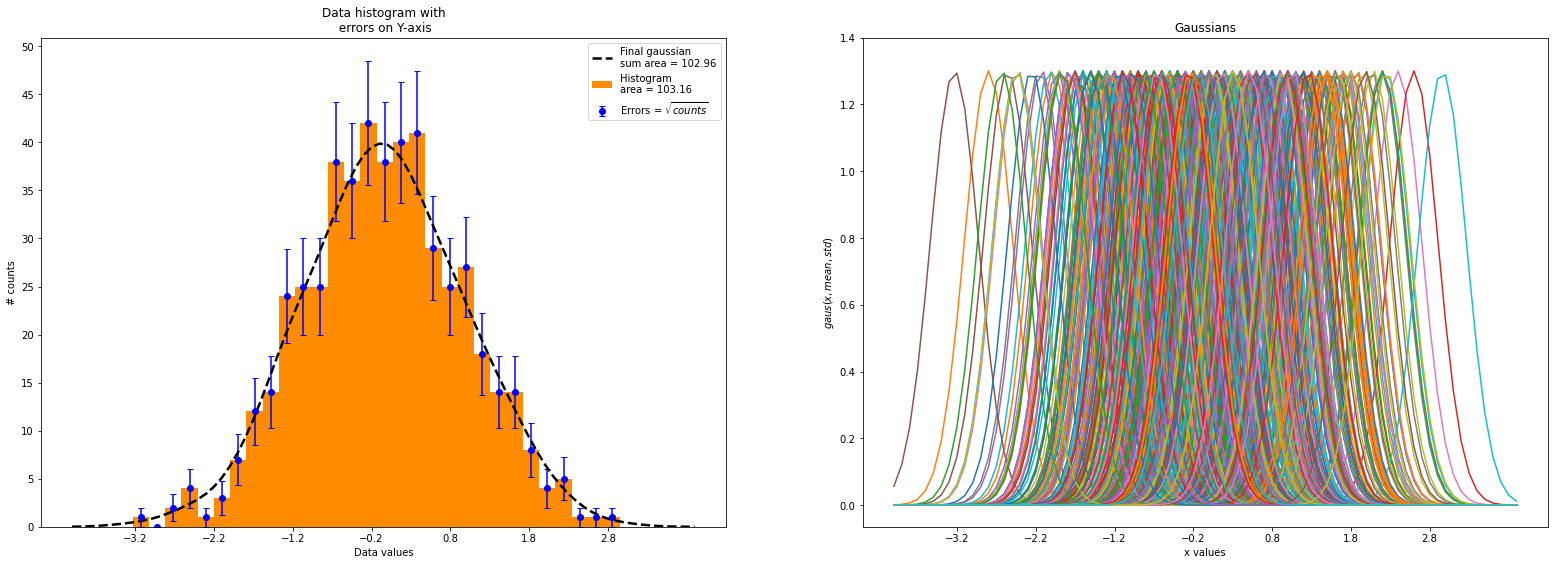

In [7]:
np.random.seed(123)
sigma, mean = 1, 0
x = sigma*np.random.randn(500)+mean
n_bins = 30
x_val, y_val = np.arange(np.round(x.min(),1), np.round(x.max(),1), 1), np.arange(0, 56, 5)

# Histogram with error bars

counts, vals = np.histogram(x, n_bins)
area_hist = sum(np.diff(vals)*counts) #sum of little rectangles areas
y_err = counts**(1/2)
half_bin = (vals[0:n_bins] + vals[1:n_bins+1])/2

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (27,9))
ax1.hist(x, bins = n_bins, color = "darkorange", label = f"Histogram\narea = {round(area_hist, 2)}")
ax1.errorbar(half_bin, counts, yerr=y_err, fmt = 'o', c = "b", capsize = 3, label = "Errors = $\sqrt{counts}$")
ax1.set(title = 'Data histogram with\n errors on Y-axis', xlabel = 'Data values', ylabel = '# counts', xticks = x_val, yticks = y_val)

# Gaussians plot

x_values = np.arange(-4, 4, 0.1)
y_values = np.arange(0, 1.5, 0.2)
std_def = 1.06*x.std()*x.size**(-1/5)
gaus = np.array([stats.norm(i, std_def) for i in x])

for j in range(len(gaus)):
    ax2.plot(x_values, gaus[j].pdf(x_values))
ax2.set(title = 'Gaussians', xlabel = 'x values', ylabel = '$gaus(x, mean, std)$', xticks = x_val, yticks = y_values)

# Normalized areas plot

gaussians = [gaus[i].pdf(x_values) for i in range(len(gaus))]
gaus_sum = np.sum(gaussians, axis = 0)

integ = integrate.trapz(gaus_sum, x_values) 
gaus_sum_norm = gaus_sum/integ
hist_norm = integrate.trapz(counts, half_bin)  # final area of gaussian sum
gaus_hist_norm = gaus_sum_norm*hist_norm
ax1.plot(x_values, gaus_hist_norm, "k--", linewidth = 2.5, label = f"Final gaussian\nsum area = {round(hist_norm, 2)}")
ax1.legend(loc = "upper right")

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

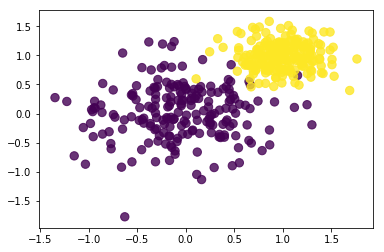

In [4]:
#!wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

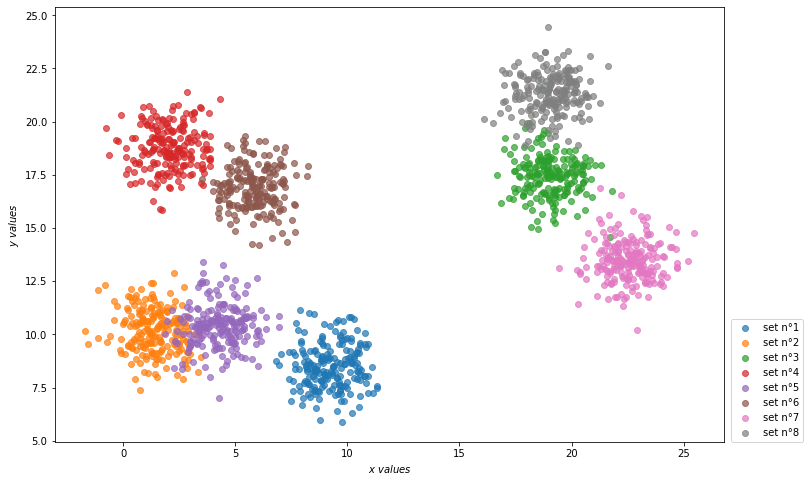

In [10]:
def _2D_dataset(sigma, mu1, mu2, n_data):
    set_x = sigma*np.random.randn(n_data) + mu1
    set_y = sigma*np.random.randn(n_data) + mu2
    return set_x, set_y
N = 8
coordinates = []
fig = plt.figure(figsize=(12,8))
for i in range(N):
    coordinates.append(_2D_dataset(1, np.random.uniform(0,25), np.random.uniform(0,25), 200))
    plt.scatter(coordinates[0][0], coordinates[0][1], alpha = 0.7, label = f"set n°{i+1}")
    coordinates.clear()
plt.xlabel("$x\ values$")
plt.ylabel("$y\ values$")
plt.legend(loc = (1.01,0))

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

,residuals,distances,bins
0,1.100000,16.0,9
1,-1.950000,6.3,4
8,-0.042857,3.3,2
9,0.128571,5.3,3
10,0.085714,15.0,8
...,...,...,...
11126,-0.760000,14.4,8
11127,0.380000,7.5,4
11128,0.083333,1.7,1
11129,0.166667,19.1,10


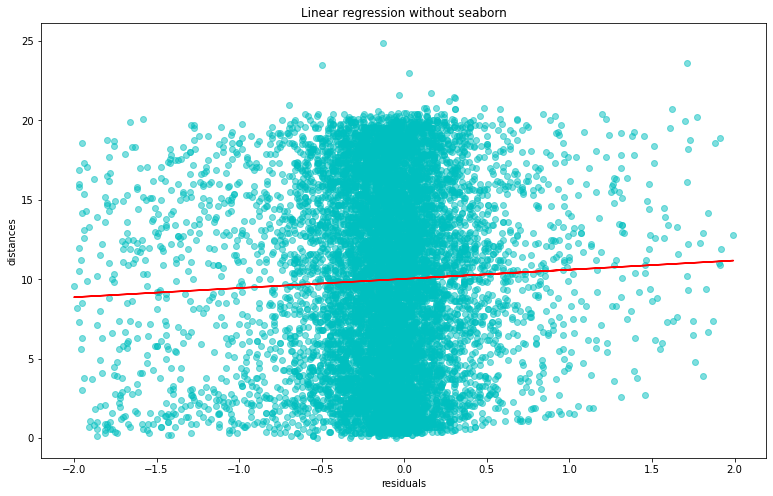

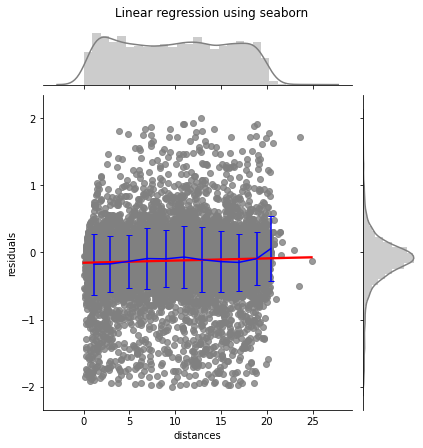

In [127]:
data_load = np.load("residuals_261.npy", allow_pickle = True)
df = pd.DataFrame(data_load.item())
df = df[abs(df['residuals']) < 2]  #filtered DataFrame

#Linear regression with scipy.stats.linregress()

k, q, r_val, p_val, std_err = stats.linregress(df['residuals'], df['distances'])
x, y = df1["residuals"], k*df1["residuals"] + q
fig, ax1 = plt.subplots(1,1,figsize = (13,8))
ax1.scatter(df1["residuals"], df1["distances"], c = "c", alpha = 0.5)
ax1.set(xlabel = "residuals", ylabel = "distances", title = "Linear regression without seaborn")
ax1.plot(x, y, "r")

#Using seaborn

xrange = np.arange(0,21,2)
df['bins'] = np.digitize(df['distances'], xrange)
mean, std_dev = df.groupby(['bins']).mean(), df.groupby(['bins']).std()
x, y, erry = mean['distances'], mean['residuals'], std_dev['residuals']
joint = sns.jointplot(x = "distances", y = "residuals", data = df, kind = "reg", color = "grey", joint_kws = {'line_kws':{'color':'r'}})
joint.fig.suptitle("Linear regression using seaborn", y = 1.03)
plt.errorbar(x, y, yerr = erry, color = 'b', capsize = 3)
display(df)